## Penjelasan Dataset yang digunakan

In [12]:
## Berikan penjelasan terkait data apa yang digunakan diantaranya:
# 1. Kasus yang diambil
# Kasus yang dianalisis adalah Analisis Sentimen 2 Kelas (Biner: Positif / Negatif)
# pada dataset "Spotify App Reviews 2022" dari Kaggle.
# Kita akan membandingkan performa model Machine Learning (Logistic Regression) 
# dengan model Deep Learning (RoBERTa pre-trained) untuk klasifikasi sentimen ini.

# 2. Penjelasan setiap kolomnya
# Dataset 'reviews.csv' memiliki beberapa kolom, namun yang akan kita gunakan adalah:
# - Review: Teks mentah opini atau review yang ditulis oleh pengguna. (Akan jadi fitur X)
# - Rating: Rating bintang (1-5) yang akan kita gunakan untuk membuat label sentimen Y
#   (Rating 1-2 = Negatif, Rating 4-5 = Positif. Rating 3 akan DIBUANG).

# 3. Import library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time

# Library untuk Model Machine Learning (ML)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # <-- MODEL ML KITA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk Model Deep Learning (DL)
print("Memastikan library ML/DL terinstall...")
!pip install scikit-learn --quiet

# Library untuk Model Prediksi Emosi (Hugging Face - INI MODEL DL KITA)
print("Memastikan library Hugging Face terinstall...")
!pip install transformers torch tf-keras --quiet
from transformers import pipeline
import torch

# Download resource NLTK (jalankan sekali saja)
print("\nMendownload resource NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("Resource NLTK siap.")

print("\nSemua library berhasil di-import.")

# 4. Load data
try:
    df = pd.read_csv('reviews.csv')
    df.columns = df.columns.str.strip()
    print(f"\nData berhasil di-load. Jumlah baris awal: {df.shape[0]}")
    print(f"Nama kolom: {df.columns.tolist()}")
    display(df.head())
except FileNotFoundError:
    print("\n--- ERROR --- File 'reviews.csv' tidak ditemukan.")
except Exception as e:
    print(f"Error saat load data: {e}")

Memastikan library ML/DL terinstall...
Memastikan library Hugging Face terinstall...

Mendownload resource NLTK...
Resource NLTK siap.

Semua library berhasil di-import.

Data berhasil di-load. Jumlah baris awal: 61594
Nama kolom: ['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply']


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


## Data Understanding

--- Info Data Awal (Sebelum Filter) ---
Data awal: 61594 baris
Jumlah baris setelah cleaning: 61356


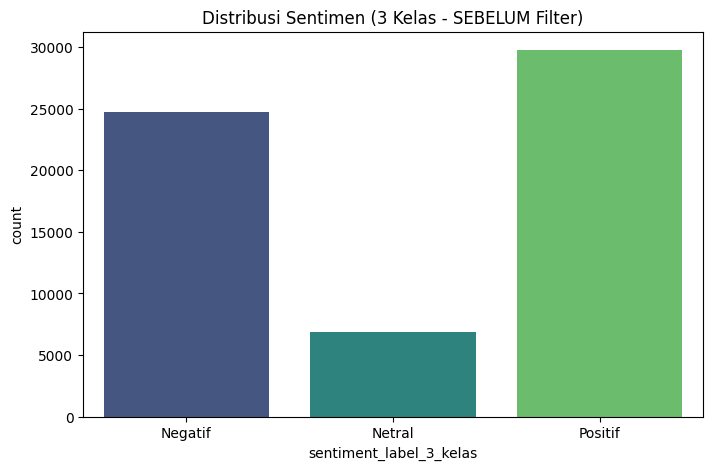


--- MEMBUANG DATA 'NETRAL' (RATING 3) ---
Jumlah baris setelah membuang 'Netral': 54480


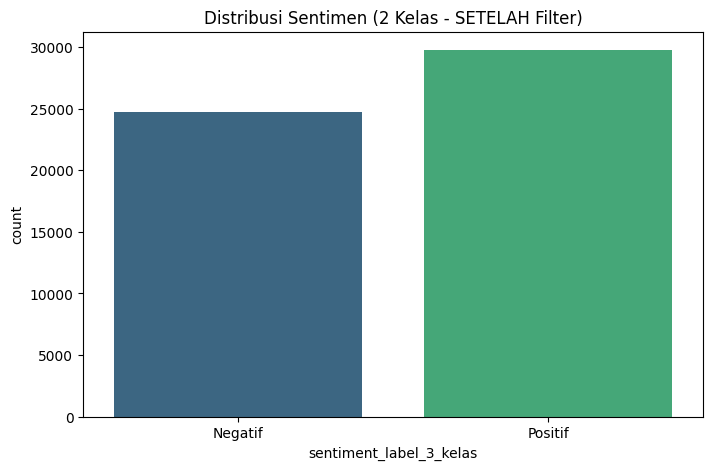


Word Cloud (Hanya data Negatif & Positif):


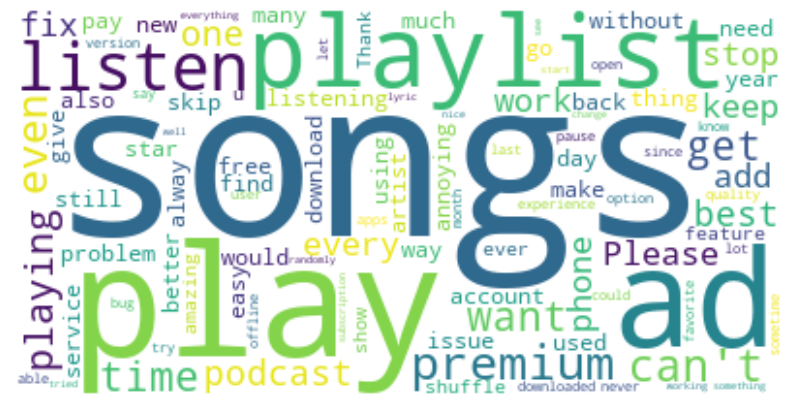

In [13]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Cleaning Awal
print("--- Info Data Awal (Sebelum Filter) ---")
print(f"Data awal: {df.shape[0]} baris")
df.dropna(subset=['Review'], inplace=True)
df.drop_duplicates(subset=['Review'], inplace=True, keep='first')
print(f"Jumlah baris setelah cleaning: {df.shape[0]}")

# 2. Buat Label 3 Kelas (untuk nunjukkin data Netral)
def map_sentiment_3_kelas(rating):
    rating = int(rating)
    if rating <= 2: return 'Negatif'
    elif rating == 3: return 'Netral'
    else: return 'Positif'
df['sentiment_label_3_kelas'] = df['Rating'].apply(map_sentiment_3_kelas)

# 3. Plot Data 3 Kelas (Sebelum Filter)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label_3_kelas', data=df, palette='viridis', order=['Negatif', 'Netral', 'Positif'])
plt.title('Distribusi Sentimen (3 Kelas - SEBELUM Filter)')
plt.show()

# --- 4. Filter Data (Buang 'Netral') ---
print("\n--- MEMBUANG DATA 'NETRAL' (RATING 3) ---")
df_binary = df[df['sentiment_label_3_kelas'] != 'Netral'].copy()
print(f"Jumlah baris setelah membuang 'Netral': {df_binary.shape[0]}")

# 5. Buat Label Biner (0 = Negatif, 1 = Positif)
df_binary['label_encoded'] = df_binary['sentiment_label_3_kelas'].map({'Negatif': 0, 'Positif': 1})

# 6. Plot Data 2 Kelas (DATA BARU)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label_3_kelas', data=df_binary, palette='viridis', order=['Negatif', 'Positif'])
plt.title('Distribusi Sentimen (2 Kelas - SETELAH Filter)')
plt.show()

# 7. Word cloud (dari data 2 kelas)
print("\nWord Cloud (Hanya data Negatif & Positif):")
text = " ".join(review for review in df_binary.Review.astype(str)) 
stop_words_wc = set(stopwords.words('english'))
stop_words_wc.update(['app', 'spotify', 'music', 'song', 'good', 'great', 'like', 'love', 'really', 'use', 'app', 'update'])
wordcloud = WordCloud(stopwords=stop_words_wc, background_color="white", max_words=100, collocations=False).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Text Processing

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 1-5. Preprocessing Teks (Lengkap untuk ML)
stop_words_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_full(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    tokens = nltk.word_tokenize(text)
    clean_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words_set and len(word) > 2
    ]
    return " ".join(clean_tokens)

print("Melakukan preprocessing teks lengkap (butuh waktu bbrp menit)...")
df_binary['clean_review'] = df_binary['Review'].apply(preprocess_text_full)
print("Preprocessing teks selesai.")

# 7. Labeling data (sudah dilakukan di Cell 4)

# 9. Data splitting (Gunakan data 'df_binary')
X_clean_ml = df_binary['clean_review'] # Ini teks 'hancur' buat ML
X_asli_dl = df_binary['Review']       # Ini teks ASLI buat DL (RoBERTa)
y_labels = df_binary['label_encoded']   # Ini label 0 dan 1

# --- INI BAGIAN YANG DIBENERIN ---
# Kita split semua data bareng-bareng
X_train, X_test, y_train, y_test, X_train_asli, X_test_asli = train_test_split(
    X_clean_ml, y_labels, X_asli_dl, test_size=0.2, random_state=42, stratify=y_labels
)
# ---------------------------------

print(f"\nData training (binary): {X_train.shape[0]}")
print(f"Data testing (binary): {X_test.shape[0]}")
print(f"Data testing (teks asli): {X_test_asli.shape[0]}") # Harusnya 10896
print(f"Data testing (label): {y_test.shape[0]}")       # Harusnya 10896

# 8. Text Vektorisasi (Hanya TF-IDF untuk X_train)
print("\nMembuat TF-IDF Vectorizer untuk ML...")
vectorizer_tfidf = TfidfVectorizer(max_features=10000) # Naikin jadi 10k
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)
print("TF-IDF siap.")

Melakukan preprocessing teks lengkap (butuh waktu bbrp menit)...
Preprocessing teks selesai.

Data training (binary): 43584
Data testing (binary): 10896
Data testing (teks asli): 10896
Data testing (label): 10896

Membuat TF-IDF Vectorizer untuk ML...
TF-IDF siap.


## Data Modeling

In [15]:
# Berikan Penjelasan tentang model yang dipilih
# 1. Machine Learning: Logistic Regression (Dilatih & di-Tuning di cell ini)
# 2. Deep Learning: RoBERTa (Model pre-trained, di-load di cell ini)

from transformers import pipeline
import torch
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# --- 1. Model Machine Learning: Logistic Regression (ML) ---
print("--- Melatih Model 1: LogisticRegression (ML) dengan Tuning ---")
print("Mencari parameter terbaik untuk TF-IDF dan LogisticRegression...")

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])

# Parameter grid yang lebih agresif untuk ngejar 90%+
param_grid = {
    'tfidf__ngram_range': [(1, 2)],  # (1,2) n-grams biasanya paling bagus
    'tfidf__max_features': [10000], # Pakai 10000 kata
    'clf__C': [5.0, 10.0]           # Pakai C yang kuat
}

grid_search = GridSearchCV(
    estimator=pipeline_lr, 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

try:
    grid_search.fit(X_train, y_train)

    print("\n--- Tuning Selesai ---")
    print(f"Parameter terbaik yang ditemukan: {grid_search.best_params_}")
    print(f"Skor F1-Weighted terbaik (CV): {grid_search.best_score_:.4f}")

    ml_model = grid_search.best_estimator_ 
    print("Model LogisticRegression (ML) terbaik sudah disimpan.")

except NameError:
    print("ERROR: Variabel 'X_train' atau 'y_train' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Cell 6.")
    raise
except Exception as e:
    print(f"Terjadi error saat melatih: {e}")

# --- 2. Model Deep Learning: Neural Network (RoBERTa) ---
print("\n--- Me-load Model 2: Deep Learning (RoBERTa) ---")
print("Loading model 'SamLdowe/roberta-base-go_emotions' untuk analisis...")
try:
    emotion_classifier = pipeline(
        "text-classification", 
        model="SamLowe/roberta-base-go_emotions", 
        return_all_scores=True
    )
    print("Model GoEmotions (28 emosi) siap.")
except Exception as e:
    print(f"Gagal load model Hugging Face: {e}")
    print("Pastikan sudah 'pip install tf-keras' dan internet stabil.")
    emotion_classifier = None

--- Melatih Model 1: LogisticRegression (ML) dengan Tuning ---
Mencari parameter terbaik untuk TF-IDF dan LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

--- Tuning Selesai ---
Parameter terbaik yang ditemukan: {'clf__C': 5.0, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Skor F1-Weighted terbaik (CV): 0.8788
Model LogisticRegression (ML) terbaik sudah disimpan.

--- Me-load Model 2: Deep Learning (RoBERTa) ---
Loading model 'SamLdowe/roberta-base-go_emotions' untuk analisis...


Device set to use cpu


Model GoEmotions (28 emosi) siap.


## Data Evaluasi

--- Evaluasi Model 1: LogisticRegression (ML) ---


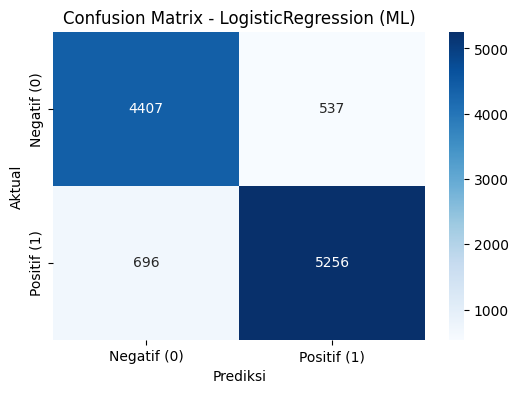


Laporan Klasifikasi - LogisticRegression (ML):
              precision    recall  f1-score   support

 Negatif (0)       0.86      0.89      0.88      4944
 Positif (1)       0.91      0.88      0.90      5952

    accuracy                           0.89     10896
   macro avg       0.89      0.89      0.89     10896
weighted avg       0.89      0.89      0.89     10896



--- BAGIAN 2: EVALUASI Model DL (RoBERTa - 28 Emosi) ---
Ini akan SANGAT LAMA... Menganalisis 1000 review acak dari test set...


Menganalisis Emosi (RoBERTa): 100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]



Analisis RoBERTa selesai.

--- Visualisasi Distribusi Emosi (Model GoEmotions) ---


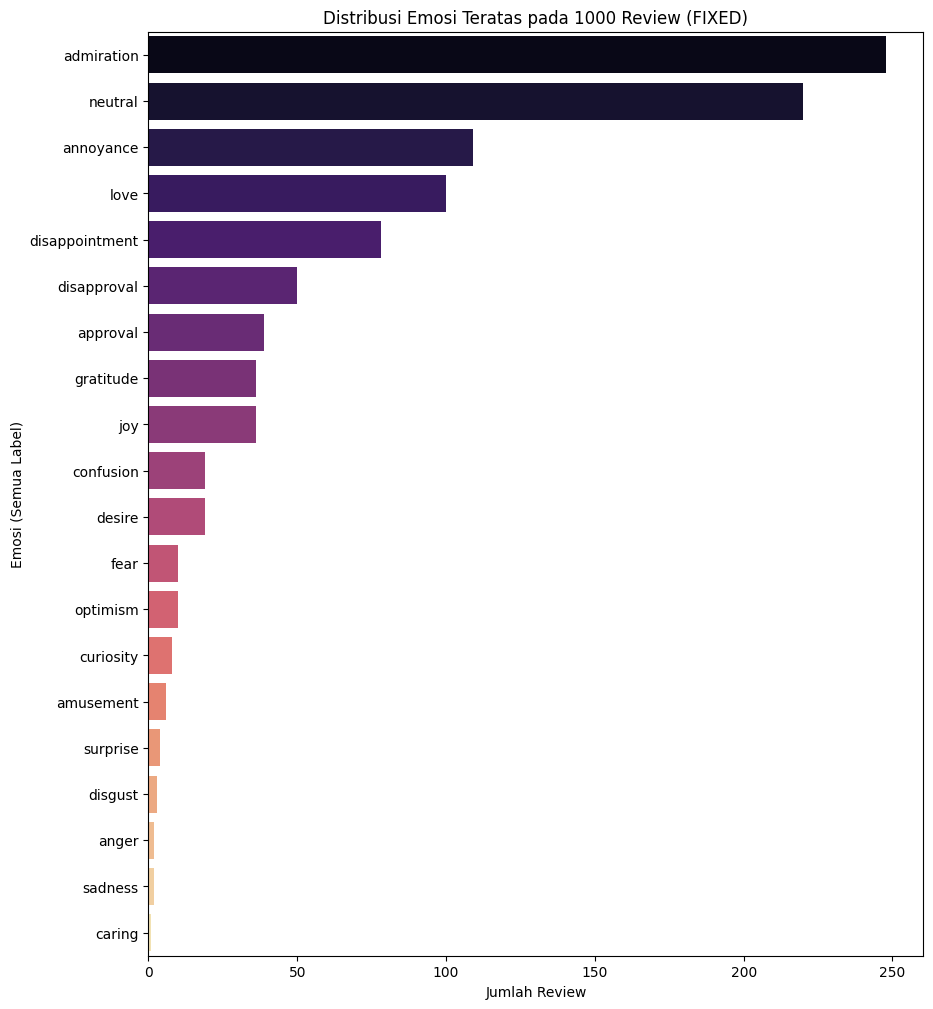


--- Visualisasi Perbandingan Emosi vs Rating Bintang ---


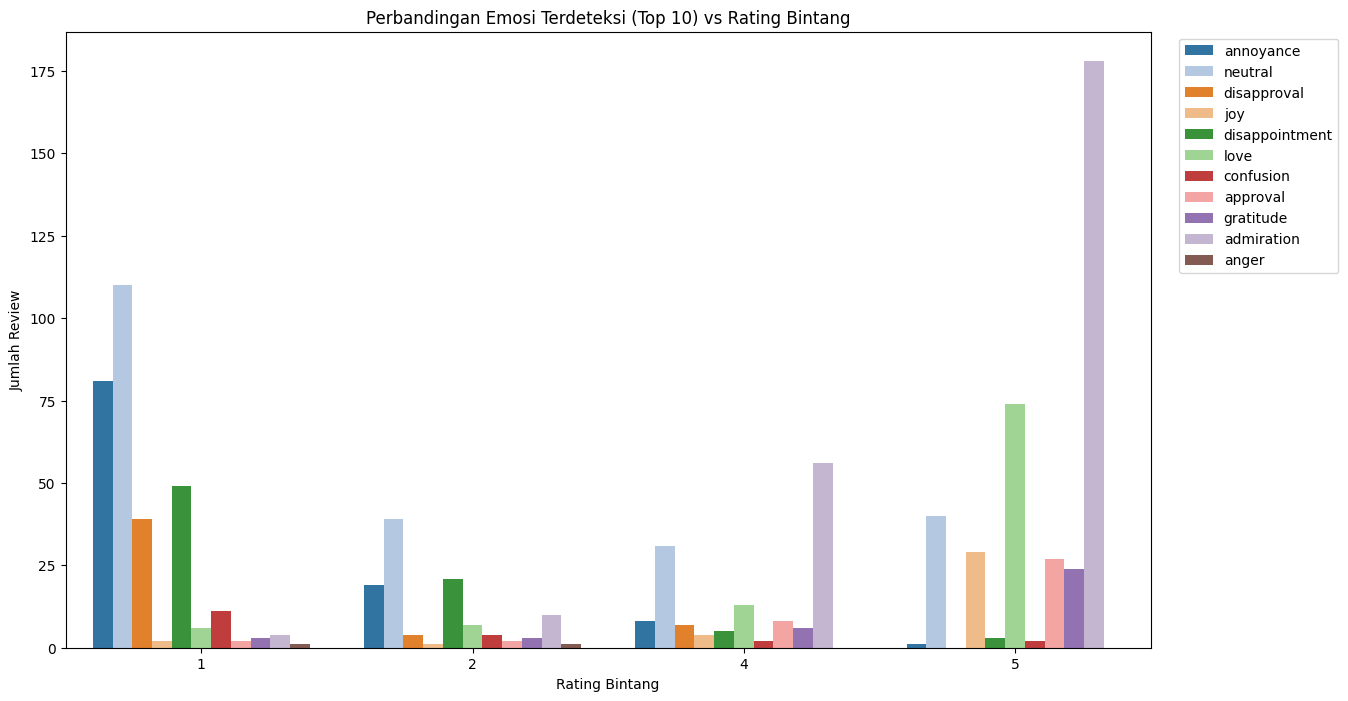


Laporan Klasifikasi - RoBERTa (DL):
              precision    recall  f1-score   support

 Negatif (0)       0.87      0.78      0.82       454
 Positif (1)       0.83      0.90      0.86       546

    accuracy                           0.85      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.85      0.85      1000



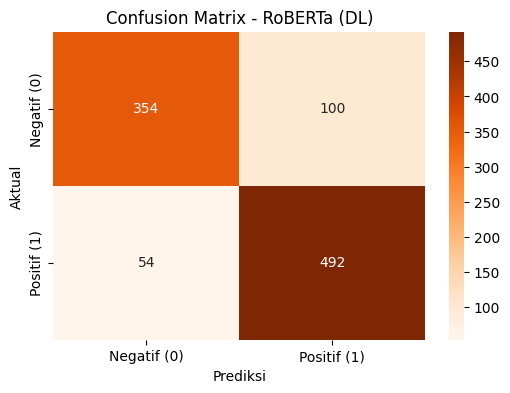



--- BAGIAN 3: VISUALISASI PERBANDINGAN MODEL ---


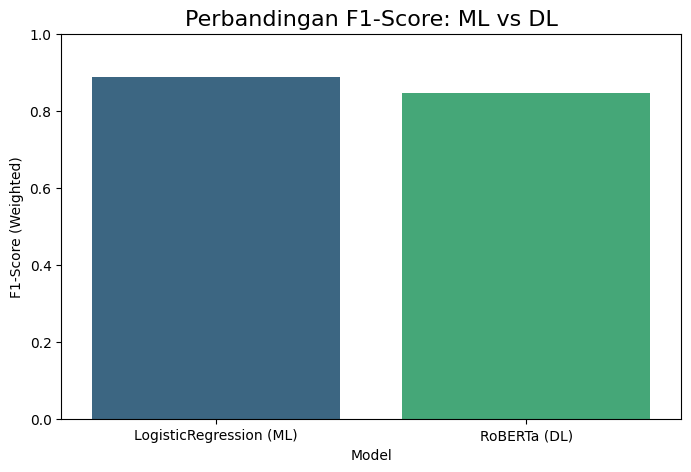

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.utils import resample
from tqdm.auto import tqdm # Import tqdm untuk progress bar

# Matikan warning yg tidak penting
import warnings
warnings.filterwarnings("ignore")

# Pastikan variabel dari cell 8 sudah ada
try:
    ml_model # Model ML (LogisticRegression)
    emotion_classifier # Model DL (RoBERTa)
except NameError:
    print("ERROR: Model 'ml_model' atau 'emotion_classifier' tidak ditemukan.")
    print("PASTIKAN ANDA SUDAH MENJALANKAN CELL 8 SEBELUMNYA!")
    raise

# --- BAGIAN 1: EVALUASI Model ML (LogisticRegression) ---
# (Ini Bagian yang 89% tadi, sudah benar)
print("--- Evaluasi Model 1: LogisticRegression (ML) ---")
ml_pred = ml_model.predict(X_test) 
target_names_binary = ['Negatif (0)', 'Positif (1)']
cm_ml = confusion_matrix(y_test, ml_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ml, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_binary, yticklabels=target_names_binary)
plt.title('Confusion Matrix - LogisticRegression (ML)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()
print("\nLaporan Klasifikasi - LogisticRegression (ML):")
ml_report_dict = classification_report(y_test, ml_pred, target_names=target_names_binary, output_dict=True)
print(classification_report(y_test, ml_pred, target_names=target_names_binary))

print("\n" + "="*50 + "\n")

print("--- BAGIAN 2: EVALUASI Model DL (RoBERTa - 28 Emosi) ---")
print("Ini akan SANGAT LAMA... Menganalisis 1000 review acak dari test set...")

# 1. Ambil sampel 1000 data dari Test Set
X_test_dl_sample, y_test_dl_sample = resample(X_test_asli, y_test, n_samples=1000, random_state=42, stratify=y_test)

# 2. Buat Peta Emosi
POSITIVE_EMOTIONS = ['admiration', 'amusement', 'approval', 'caring', 'curiosity', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief', 'surprise']
NEGATIVE_EMOTIONS = ['anger', 'annoyance', 'confusion', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']

# 3. Fungsi cleaning ringan
def clean_text_light(text):
    text = str(text).lower(); text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE); text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text); text = re.sub(r'\s+', ' ', text).strip(); return text

# 4. Fungsi Analisis RoBERTa (FIX: return_all_scores=True)
def analyze_roberta(review):
    if pd.isna(review) or review.strip() == "" or emotion_classifier is None:
        return ('neutral', 1) # Default ke 'neutral' dan 'Positif' (ANGKA 1)
    
    review_clean = clean_text_light(review)
    if review_clean == "": return ('neutral', 1) # Default ke 'neutral' dan 'Positif' (ANGKA 1)
    review_terpotong = review_clean[:510] 
    
    try:
        results = emotion_classifier(review_terpotong)
        scores = {item['label']: item['score'] for item in results[0]}
        
        # --- Bagian A: Cari Emosi Teratas (buat plot magma) ---
        top_emotion_label = 'neutral'
        top_emotion_score = 0
        for label, score in scores.items():
            if score > top_emotion_score:
                top_emotion_score = score
                top_emotion_label = label
        if top_emotion_score < 0.2:
            top_emotion_label = 'neutral'

        # --- Bagian B: Cari Prediksi Biner (buat report) ---
        max_positive_score = max(scores[label] for label in POSITIVE_EMOTIONS)
        max_negative_score = max(scores[label] for label in NEGATIVE_EMOTIONS)
        
        # --- INI FIX-NYA ---
        binary_pred = 1 if max_positive_score > max_negative_score else 0 # <-- Kembalikan ANGKA 0 atau 1
            
        return (top_emotion_label, binary_pred)
            
    except Exception as e:
        return ('error', 1) # Default ke 'error' dan 'Positif' (ANGKA 1)

# 5. Terapkan prediksi (INI YANG LAMA)
tqdm.pandas(desc="Menganalisis Emosi (RoBERTa)")
results = X_test_dl_sample.progress_apply(analyze_roberta)
print("\nAnalisis RoBERTa selesai.")

# 6. Pisahkan hasilnya
y_pred_roberta_binary = results.apply(lambda x: x[1]) # Ini label 0/1 (ANGKA)
emotion_labels = results.apply(lambda x: x[0])     # Ini label 'joy', 'anger', dll.

# --- INI DIA PLOT EMOSI YANG LU CARI (FIXED) ---
print("\n--- Visualisasi Distribusi Emosi (Model GoEmotions) ---")
plt.figure(figsize=(10, 12)) 
emotion_counts = emotion_labels.value_counts()
sns.barplot(x=emotion_counts.values, y=emotion_counts.index, orient='h', palette='magma')
plt.title(f'Distribusi Emosi Teratas pada {len(X_test_dl_sample)} Review (FIXED)')
plt.xlabel('Jumlah Review')
plt.ylabel('Emosi (Semua Label)')
plt.show()

# --- INI PLOT EMOSI VS RATING (FIXED) ---
print("\n--- Visualisasi Perbandingan Emosi vs Rating Bintang ---")
df_sample_with_rating = df.loc[X_test_dl_sample.index].copy()
df_sample_with_rating['emotion'] = emotion_labels
top_10_emotions = emotion_counts.head(10).index.tolist()
if 'anger' not in top_10_emotions: top_10_emotions.append('anger')
if 'disappointment' not in top_10_emotions: top_10_emotions.append('disappointment')
df_plot = df_sample_with_rating[df_sample_with_rating['emotion'].isin(top_10_emotions)]
plt.figure(figsize=(14, 8))
sns.countplot(x='Rating', data=df_plot, hue='emotion', palette='tab20', order=[1, 2, 4, 5]) 
plt.title('Perbandingan Emosi Terdeteksi (Top 10) vs Rating Bintang')
plt.xlabel('Rating Bintang')
plt.ylabel('Jumlah Review')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

# --- INI CLASSIFICATION REPORT ROBERTA (FIXED) ---
print("\nLaporan Klasifikasi - RoBERTa (DL):")
# 'y_test_dl_sample' (kunci jawaban) isinya ANGKA 0/1
# 'y_pred_roberta_binary' (tebakan) SEKARANG isinya ANGKA 0/1
roberta_report_dict = classification_report(y_test_dl_sample, y_pred_roberta_binary, target_names=target_names_binary, output_dict=True, zero_division=0)
print(classification_report(y_test_dl_sample, y_pred_roberta_binary, target_names=target_names_binary, zero_division=0))

# --- INI CONFUSION MATRIX ROBERTA (FIXED) ---
cm_dl = confusion_matrix(y_test_dl_sample, y_pred_roberta_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names_binary, yticklabels=target_names_binary)
plt.title('Confusion Matrix - RoBERTa (DL)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

print("\n" + "="*50 + "\n")
print("--- BAGIAN 3: VISUALISASI PERBANDINGAN MODEL ---")

# Ambil F1-score (weighted) dari kedua model
ml_f1 = ml_report_dict['weighted avg']['f1-score']
dl_f1 = roberta_report_dict['weighted avg']['f1-score']

df_compare = pd.DataFrame({
    'Model': ['LogisticRegression (ML)', 'RoBERTa (DL)'],
    'F1-Score (Weighted)': [ml_f1, dl_f1]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='F1-Score (Weighted)', data=df_compare, palette='viridis')
plt.title('Perbandingan F1-Score: ML vs DL', fontsize=16)
plt.ylabel('F1-Score (Weighted)')
plt.ylim(0, 1.0)
plt.show()

## Data Prediksi

In [17]:
# Gunakan model yang sudah dibuat dan prediksi pada data baru
import pandas as pd
import numpy as np
import re
import time

# --- 1. Definisikan Ulang Fungsi & Model (biar aman) ---
# (Fungsi-fungsi ini diperlukan jika kernel di-restart)

# Fungsi cleaning RINGAN (untuk RoBERTa)
def clean_text_light(text):
    text = str(text).lower(); text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE); text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text); text = re.sub(r'\s+', ' ', text).strip(); return text

# Cek apakah model-model dari Cell 8 sudah ada di memori
try:
    ml_model # Model ML (LogisticRegression)
    emotion_classifier # Model DL (RoBERTa)
    print("Model ML (LogisticRegression) dan DL (RoBERTa) sudah di-load dari cell sebelumnya.")
except NameError:
    print("WARNING: Model tidak ditemukan. Menjalankan ulang Cell 8 mungkin diperlukan.")
    print("Mencoba me-load ulang model (ini akan lama)...")
    
    # Jika 'ml_model' tidak ada (meskipun seharusnya ada)
    # Ini cuma buat jaga-jaga, seharusnya 'ml_model' sudah ada
    if 'ml_model' not in locals():
        print("ERROR: 'ml_model' tidak ada. Jalankan ulang Cell 8.")
        
    # Jika 'emotion_classifier' tidak ada, kita load ulang
    if 'emotion_classifier' not in locals():
        try:
            from transformers import pipeline; import torch
            emotion_classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", return_all_scores=True)
            print("Model GoEmotions (28 emosi) siap.")
        except Exception as e:
            print(f"Gagal load model Hugging Face: {e}"); emotion_classifier = None
except Exception as e:
    print(f"Error aneh: {e}")


# --- 2. Siapkan Kalimat Prediksi (BAHASA INGGRIS SEMUA) ---
print("\n" + "="*50)
print("--- Memulai Prediksi Data Baru ---")

review_positif = "I absolutely love spotify, i use it every single day."
review_negatif = "This new update is terrible. It keeps crashing. I hate it!"
review_netral = "This is a music streaming application, it works okay." # Ini akan dipaksa jadi Pos/Neg
review_kecewa = "It used to be good, but now there are way too many ads. Very disappointing."
review_kagum = "The algorithm is genius. It knows exactly what I want to listen to."

reviews_baru = [review_positif, review_negatif, review_netral, review_kecewa, review_kagum]
label_map_binary = {0: 'Negatif', 1: 'Positif'} # Peta label 0/1

for review in reviews_baru:
    print("\n" + "="*50)
    print(f"Review Baru: \"{review}\"")
    
    # --- 3. Prediksi Model ML (LogisticRegression) ---
    # Model 'ml_model' adalah pipeline, jadi dia otomatis memproses teks mentah
    try:
        # 'ml_model' (dari Cell 8) sudah termasuk (TF-IDF + LogisticRegression)
        ml_prediction_idx = ml_model.predict([review])[0]
        print(f"   > Prediksi LogisticRegression (ML): {label_map_binary[ml_prediction_idx]}")
    except Exception as e:
        print(f"   > Error saat prediksi ML: {e}")
    
    # --- 4. Analisis Emosi Mendalam (RoBERTa - DL) ---
    print("\n   --- Analisis Emosi Mendalam (RoBERTa - DL) ---")
    review_hf = clean_text_light(review)
    if emotion_classifier:
        try:
            hasil_emosi = emotion_classifier(review_hf)
            hasil_df = pd.DataFrame(hasil_emosi[0]).sort_values(by='score', ascending=False)
            print(f"   5 Emosi Teratas yang Terdeteksi:")
            display(hasil_df.head(5))
        except Exception as e:
            print(f"   Error saat prediksi emosi: {e}")
    else:
        print("   Model GoEmotions tidak berhasil di-load, analisis emosi di-skip.")

print("\n" + "="*50)
print("--- Prediksi Selesai ---")

Model ML (LogisticRegression) dan DL (RoBERTa) sudah di-load dari cell sebelumnya.

--- Memulai Prediksi Data Baru ---

Review Baru: "I absolutely love spotify, i use it every single day."
   > Prediksi LogisticRegression (ML): Positif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
18,love,0.955775
0,admiration,0.051288
4,approval,0.027753
17,joy,0.011316
15,gratitude,0.011124



Review Baru: "This new update is terrible. It keeps crashing. I hate it!"
   > Prediksi LogisticRegression (ML): Negatif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
14,fear,0.448785
2,anger,0.279897
3,annoyance,0.148559
11,disgust,0.135204
10,disapproval,0.048398



Review Baru: "This is a music streaming application, it works okay."
   > Prediksi LogisticRegression (ML): Positif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
4,approval,0.843915
27,neutral,0.122427
0,admiration,0.048503
20,optimism,0.027277
22,realization,0.015800



Review Baru: "It used to be good, but now there are way too many ads. Very disappointing."
   > Prediksi LogisticRegression (ML): Negatif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
9,disappointment,0.872291
3,annoyance,0.128134
10,disapproval,0.077113
25,sadness,0.066524
27,neutral,0.056220



Review Baru: "The algorithm is genius. It knows exactly what I want to listen to."
   > Prediksi LogisticRegression (ML): Positif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
0,admiration,0.918420
4,approval,0.147714
27,neutral,0.027052
13,excitement,0.008716
20,optimism,0.007849



--- Prediksi Selesai ---
